In [1]:
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from obspy import read
from matplotlib import cm
import matplotlib.gridspec as gridspec
import os
import datetime as dtt
import matplotlib.patches
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from  sklearn.preprocessing import StandardScaler
import sys
from matplotlib.patches import Rectangle
import sklearn.metrics
from scipy import spatial
import matplotlib.image as mpimg
import obspy
from scipy.signal import butter, lfilter
import librosa
# sys.path.insert(0, '../01_DataPrep')
from scipy.io import loadmat
from sklearn.decomposition import PCA
import scipy.io as spio
sys.path.append('.')
from sklearn.metrics import silhouette_samples
import seaborn as sns
import scipy as sp
import scipy.io as spio
import scipy.signal

sys.path.append('/Users/theresasawi/Documents/specufex_20210614/')
sys.path.append('/Users/theresasawi/Documents/specufex_20210614/4_visualize/functions/')
import paths
from sklearn.cluster import KMeans
# import figureFunctions

In [2]:
import figureFunctions2

In [3]:
from functions2 import getFeatures, getLocationFeatures,getNMFOrder,resortByNMF,getSpectra_fromWF,getSgram
from functions2 import PCAonFP,calcSilhScore,getDailyTempDiff,getSpectraMedian,CalcDiffPeak,PVEofPCA,getTopFCat

## get paths

In [4]:
#%% load project variables: names and paths
# key = sys.argv[1]

key = "BB_Gorner_Event_Final_v11_J8"
keyN = "BB_Gorner_Cont_Final_v10_J8"


filetype = '.gse2'     
Kopt =3

filetypeN = '.sac' 
KoptN =4
    



mode = 'fingerprints'#'kernalPCA'#'fingerprints'#'PCA' 


clus_sel = [1,2,3]
sel_state = [12,14,8]

clus_selN = [1,2,3,4]
sel_stateN = [6,3,5,4]


leg = ['During/after flood','Before flood','PM']
legN = ['During/after flood','Before flood','Rain?','PM']




print(key,mode,Kopt, ' clusters')

p = paths.returnp(key)
pN = paths.returnp(keyN)

#%%

projName        = p['projName']
datasetID       = p['datasetID']
projName        = p['projName']
station         = p['station']
channel         = p['channel']
path_top        = p['path_top']
path_proj       = p['path_proj']
outfile_name    = p['outfile_name']
dataFile_name   = p['dataFile_name']
pathFig         = p['pathFig']
path_WF         = p['path_WF']
path_FP         = p['pathFP']
subCatalog_Name = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"



pathFP          = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTM         = f'{path_top}{projName}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'

pathEB          = f'{path_top}{projName}/02_src/02_SpecUFEx/EB.mat'
pathElnB          = f'{path_top}{projName}/02_src/02_SpecUFEx/ElnB.mat'


pathW        = path_proj + '02_src/02_SpecUFEx/out.DictGain.mat' 


path_Cat        = p['path_Cat']

pathClusCat = path_proj + f"principalDf_full_{mode}_Kopt{Kopt}.csv"
dataH5_path = path_proj + dataFile_name


projNameN        = pN['projName']
datasetIDN       = pN['datasetID']
projNameN        = pN['projName']
station         = pN['station']
channel         = pN['channel']
path_top        = pN['path_top']
path_projN       = pN['path_proj']
outfile_nameN    = pN['outfile_name']
dataFile_nameN   = pN['dataFile_name']
pathFigN         = pN['pathFig']
path_WFN         = pN['path_WF']
path_FPN         = pN['pathFP']
subCatalog_NameN = f"{dataFile_name}_Sgrams_Subcatalog.hdf5"


pathFPN          = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_FEATout/'
pathACMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step2_NMF/'
pathSTMN         = f'{path_top}{projNameN}/03_output/{station}/SpecUFEx_output/step4_stateTransMats/'

pathEBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/EB.mat'
pathElnBN          = f'{path_top}{projNameN}/02_src/02_SpecUFEx/ElnB.mat'


pathWN        = path_projN + '02_src/02_SpecUFEx/out.DictGain.mat' 


path_CatN      = pN['path_Cat']

pathClusCatN = path_projN + f"principalDf_full_{mode}_Kopt{KoptN}.csv"
dataH5_pathN = path_projN + dataFile_nameN

BB_Gorner_Event_Final_v11_J8 fingerprints 3  clusters


## Load auxiliary catalog

In [5]:
# pathFig2 = '/Users/theresasawi/Documents/11_Manuscripts/Sawietal_2021/notebook_figures/'
pathFig2 = '/Users/theresasawi/Documents/11_Manuscripts/Sawietal_2021/notebook_figures_JGR/'

In [6]:
# timing of lake events 
tstart = dtt.datetime(2007, 6, 13)
tend = dtt.datetime(2007, 7, 23)
calvet = dtt.datetime(2007, 7, 1,13,41,35)
supraDraint = dtt.datetime(2007, 7, 4)
subDraint = dtt.datetime(2007, 7, 7)
drainEndt = dtt.datetime(2007, 7, 15)

In [7]:

garciaDF_H = pd.read_csv('/Users/theresasawi/Documents/SpecUFEx_v1/GARCIA_BundledData2007/temp_H.csv')
garciaDF_3H = pd.read_csv('/Users/theresasawi/Documents/SpecUFEx_v1/GARCIA_BundledData2007/garciaDF_3H.csv')
garciaDF_D = pd.read_csv('/Users/theresasawi/Documents/SpecUFEx_v1/GARCIA_BundledData2007/garciaDF_D.csv')


garciaDF_H['datetime'] = [pd.to_datetime(d) for d in garciaDF_H.datetime]
garciaDF_3H['datetime'] = [pd.to_datetime(d) for d in garciaDF_3H.datetime]
garciaDF_D['datetime'] = [pd.to_datetime(d) for d in garciaDF_D.datetime]

garciaDF_H['datetime_index'] = garciaDF_H.datetime
garciaDF_3H['datetime_index'] = garciaDF_3H.datetime
garciaDF_D['datetime_index'] = garciaDF_D.datetime

garciaDF_H = garciaDF_H.set_index('datetime_index')
garciaDF_3H = garciaDF_3H.set_index('datetime_index')
garciaDF_D = garciaDF_D.set_index('datetime_index')



# Make catalog

In [8]:
## get topF catalog


## pick representative event by highest silhouette score, or smallest euclidean distance?
topSilhScore = 1
topEucDist = 0
topF = 1
startInd = 1

distMeasure = 'SS'

In [9]:
cat_orig = pd.read_csv(path_Cat)
cat00 = pd.read_csv(pathClusCat)
# cat00 = cat00.drop('Unnamed: 0',axis=1)
cat00['event_ID'] = [str(int(evv)) for evv in cat00['event_ID']]
cat_orig['event_ID'] = [str(int(evv)) for evv in cat_orig['event_ID']]


cat_orig['datetime'] = [pd.to_datetime(i) for i in cat_orig.datetime]
cat_orig['datetime2']= [pd.to_datetime(i) for i in cat_orig.datetime]
cat_orig = cat_orig.set_index('datetime2')


cat00['datetime'] = [pd.to_datetime(i) for i in cat00.date_index]
cat00['datetime2']= [pd.to_datetime(i) for i in cat00.date_index]

if 'BB_Gorner_Event' in key: ## arg fix TS 2021 5 17
    cat00['date_index'] = [pd.to_datetime('2007' + a[4:]) for a in cat00['date_index']]

    cat00['datetime2']= cat00['date_index']
    
cat00 = cat00.set_index('datetime2')
    
cat00['datetime'] = cat00['date_index']


cat00 = pd.merge(cat00,cat_orig,on='event_ID', suffixes=('', '_drop'))
cat00.drop([col for col in cat00.columns if 'drop' in col], axis=1, inplace=True)
cat00 = cat00.set_index('date_index')


In [10]:
cat_origN = pd.read_csv(path_CatN)
cat00N = pd.read_csv(pathClusCatN)
# cat00N = cat00N.drop('Unnamed: 0',axis=1)
cat00N['event_ID'] = [str(int(evv)) for evv in cat00N['event_ID']]
cat_origN['event_ID'] = [str(int(evv)) for evv in cat_origN['event_ID']]


cat_origN['datetime'] = [pd.to_datetime(i) for i in cat_origN.datetime]
cat_origN['datetime2']= [pd.to_datetime(i) for i in cat_origN.datetime]
cat_origN = cat_origN.set_index('datetime2')


cat00N['datetime'] = [pd.to_datetime(i) for i in cat00N.date_index]
cat00N['datetime2']= [pd.to_datetime(i) for i in cat00N.date_index]

    
cat00N = cat00N.set_index('datetime2')
    
cat00N['datetime'] = cat00N['date_index']


cat00N = pd.merge(cat00N,cat_origN,on='event_ID', suffixes=('', '_drop'))
cat00N.drop([col for col in cat00N.columns if 'drop' in col], axis=1, inplace=True)
cat00N = cat00N.set_index('date_index')

In [11]:




############################################################
            ##### FORMAT DAY TICKS ######
############################################################
tstart = pd.to_datetime('2007-06-14 00:00:00')
tend   = pd.to_datetime('2007-07-22 00:00:00')

tlimstart = pd.to_datetime('2007-06-13 12:00:00')
tlimend   = pd.to_datetime('2007-07-22 12:00:00')

delta_day = 7
clus_clu_perday = cat_orig.resample('D').event_ID.count()

days_list = [clus_clu_perday.index[i] for i in range(len(clus_clu_perday))]

numDays = len(clus_clu_perday)

day_labels = [f"{days_list[d].month}-{days_list[d].date().day}" for d in range(0,len(days_list),delta_day)]

# day_labels = [f"{days_list[d].date().day}-{days_list[d].month}" for d in range(0,len(days_list),delta_day)]
day_ticks = [days_list[d] for d in range(0,len(days_list),delta_day)]


# Central European Time is 2 hours later than UTC (Coordinated Universal Time)
##max temp is around 4pm local time or 16:00, in UTC it is 14:00 or 2pm
#all times in UTC
hourMaxTemp = [dtt.datetime(2007, 6, 14,14,0,0) + pd.DateOffset(i) for i in range(0,numDays)]

# hour24labels = [str(r) for r in range(2,24)] #Convert UTC to CET
# hour24labels = hour24labels + ['0','1']
hour24labels = [str(r) for r in range(0,24)] #UTC

print(day_labels)
############################################################
############################################################

##station data 
stn = pd.read_csv("/Users/theresasawi/Documents/gorner_2007_all/stnlst.csv",
                  header=None,
                  names=['name','X','Y','Elevation','dX','dY','Depth'])

        
            

['6-14', '6-21', '6-28', '7-5', '7-12', '7-19']


# Get experiment parameters

In [12]:



with h5py.File(path_proj + dataFile_name,'r') as dataFile:

    lenData = dataFile['processing_info/'].get('lenData')[()]
    fs = dataFile['spec_parameters/'].get('fs')[()]
    
    # fmin = 
    nperseg = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlap = dataFile['spec_parameters/'].get('noverlap')[()]
    nfft = dataFile['spec_parameters/'].get('nfft')[()]


    fmax = dataFile['spec_parameters/'].get('fmax')[()]
    fmax = np.ceil(fmax)
    fmin = dataFile['spec_parameters/'].get('fmin')[()]
    fmin = np.floor(fmin)    
    fSTFT = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFT = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_mode = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scaling = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fs = int(np.ceil(fs))
winLen_Sec = float(nperseg / fs)

## specufex parameters
Wmat = loadmat(pathW)
EBmat = loadmat(pathEB)

W = Wmat.get('W1')
EB = EBmat.get('EB')



numPatterns = len(W[1])
Nfreqs = len(W)
numStates = EB.shape[0]

In [13]:



with h5py.File(path_projN + dataFile_nameN,'r') as dataFile:

    lenDataN = dataFile['processing_info/'].get('lenData')[()]
    fsN = dataFile['spec_parameters/'].get('fs')[()]
    
    # fminN = 
    npersegN = dataFile['spec_parameters/'].get('nperseg')[()]
    noverlapN = dataFile['spec_parameters/'].get('noverlap')[()]
    nfftN = dataFile['spec_parameters/'].get('nfft')[()]


    fmaxN = dataFile['spec_parameters/'].get('fmax')[()]
    fmaxN = np.ceil(fmaxN)
    fminN = dataFile['spec_parameters/'].get('fmin')[()]
    fminN = np.floor(fminN)    
    fSTFTN = dataFile['spec_parameters/'].get('fSTFT')[()]
    tSTFTN = dataFile['spec_parameters/'].get('tSTFT')[()]
    
    sgram_modeN = dataFile['spec_parameters/'].get('mode')[()].decode('utf-8')
    scalingN = dataFile['spec_parameters/'].get('scaling')[()].decode('utf-8')
    
    
fsN = int(np.ceil(fsN))
winLen_SecN = float(npersegN / fsN)

## specufex parameters
WmatN = loadmat(pathWN)
EBmatN = loadmat(pathEBN)

WN = WmatN.get('W1')
EBN = EBmatN.get('EB')



numPatternsN = len(WN[1])
NfreqsN = len(WN)
numStatesN = EBN.shape[0]

In [14]:
order_swap = getNMFOrder(W,numPatterns)
W_new = resortByNMF(W,order_swap)
EB_new = resortByNMF(EB,order_swap)

RMM = W_new @ EB_new.T

In [15]:
order_swapN = getNMFOrder(WN,numPatternsN)
W_newN = resortByNMF(WN,order_swapN)
EB_newN = resortByNMF(EBN,order_swapN)

RMMN = W_newN @ EB_newN.T

# Set plotting parameters

In [16]:
plt.rcParams['image.cmap']='magma'

plt.rcParams.update({'font.size': 8})
colors =cm.Paired(np.array([1,5,7,9,2,4,6,8]))

#% for plotting
smallfont=6
largefont=8

N = len(cat00)
NN = len(cat00N)


lw1=4        
lw2=5
alphaT=1
ylabfont=8
ylabpad =10


plt_kwargs = {'lw1':lw1,
              'lw2':lw2,
#               'numStates':numStates,
#               'numPatterns':numPatterns,
              'alphaT':alphaT,
              'ylabfont':ylabfont,
              'ylabpad':ylabpad,
              'largefont':largefont,
              'smallfont':smallfont,
              'colors':colors,
#               'path_proj':path_proj,
#               'dataFile_name':dataFile_name,
#               'fmin':fmin,
#               'fmax':fmax,
#               'winLen_Sec':winLen_Sec,
#               'station':station,
#               'fs':fs,
#               'fSTFT':fSTFT,
#               'tSTFT':tSTFT,
              'scaling':scaling,
              'sgram_mode':sgram_mode,
#               'nperseg':nperseg,
#               'noverlap':noverlap,
#               'nfft':nfft,
              'hour24labels':hour24labels,
              'day_ticks':day_ticks,
              'day_labels':day_labels,
              'numDays':numDays,
              'hourMaxTemp':hourMaxTemp,
              'tstart':tlimstart,
              'tend':tlimend,
              'tstartreal':tstart,
              'tendreal':tend
             }

## Get 3 "random" sgram IDs 

In [17]:
np.random.seed(30)

N = len(cat00.event_ID)
Nsub = 3
randID = np.random.choice(cat00.event_ID,size=int(Nsub),replace=False)
randID.sort()
randID
rand_date_list = [pd.to_datetime('200' + evID) for evID in randID]
print(rand_date_list)


np.random.seed(31)

NsubN = 3
randIDN = np.random.choice(cat00N.event_ID,size=int(NsubN),replace=False)
randIDN.sort()
randIDN
rand_date_listN = [pd.to_datetime('200' + evID) for evID in randIDN]

print(rand_date_listN)

[Timestamp('2007-06-18 10:24:07'), Timestamp('2007-06-30 15:33:07'), Timestamp('2007-07-14 14:53:56')]
[Timestamp('2007-06-19 00:37:43'), Timestamp('2007-06-26 11:23:57'), Timestamp('2007-07-18 12:12:27')]


# Figure 1 - Icequake map with depth 

In [18]:
#quarter page
width1 = 3.74016
height1 = 4.52756

#full page
width2 = 7.48031
height2 = 9.05512

Populating the interactive namespace from numpy and matplotlib


/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fmax', 'fmin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


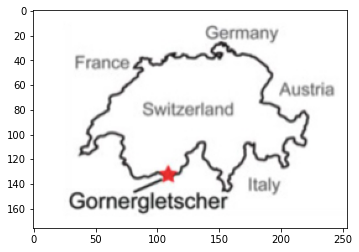

In [19]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('/Users/theresasawi/Documents/11_Manuscripts/Sawietal_2021/map_CH.jpg')
imgplot = plt.imshow(img)
plt.show()

/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
/Users/theresasawi/opt/anaconda3/envs/seismo2/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  fig.canvas.print_figure(bytes_io, **kw)


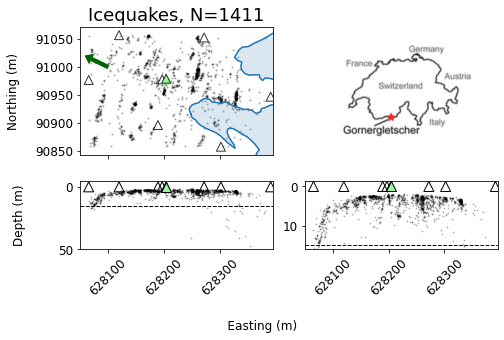

In [20]:
##v2
##settings for yellow bars
plt.rcParams.update({'font.size': 12})




fig,axes = plt.subplots(figsize = (width2,height1),sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(7,4)
gs.update(wspace=.4, hspace=0.07)

## Bar plot, Temp and Lake/Precip
ax = plt.subplot(gs[0:5,0:2])
figureFunctions2.plotMap(cat00,ax=ax,colorBy='all',size=6,alpha=.2,**plt_kwargs); #'cluster';'all';'datetime'
figureFunctions2.plotStations(stn,station,ax=ax)
ax.set_aspect('equal')
# ax.set_xticks([])
ax.set_xticklabels('')

ax.set_ylabel('Northing (m)',labelpad=15,fontsize=12)

title = f'Icequakes, N={N}'    
ax.set_title(title, pad=6,fontsize=18) 


## flow arrow
x = 628100
y = 91000
dx = -60 / 2
dy = 29 / 2
ax.arrow(x, y, dx, dy,color='darkgreen',width=6,head_length=12)


# #### plot depth and stations 
ax2 = plt.subplot(gs[5:7,0:2])

figureFunctions2.plotDepth(cat00,stn,ax=ax2,byCluster=False,size=1,alpha=.2,stasize=100,**plt_kwargs)    
ax2.set_ylabel('Depth (m)',labelpad=32,fontsize=12)
ax2.set_xlabel('                                            Easting (m)',labelpad=22,fontsize=12)

ax2.set_ylim(50,-5)
# ax2.set_aspect('1.42')
# ax.text(628100,40,'VE=4',fontsize=10)
ax2.tick_params(axis='x',labelrotation=45)
ax2.axhline(15,color='k',ls='--',lw=1)

# #### plot depth and stations zoomed in
ax2 = plt.subplot(gs[5:7,2:])

figureFunctions2.plotDepth(cat00,stn,ax=ax2,byCluster=False,size=1,alpha=.2,stasize=100,**plt_kwargs)    
ax2.set_ylabel('')
ax2.set_xlabel('')

ax2.set_ylim(16,-1.5)
ax2.axhline(15,color='k',ls='--',lw=1)

# ax2.set_aspect('1.42')
# ax.text(628100,40,'VE=4',fontsize=10)
ax2.tick_params(axis='x',labelrotation=45)


ax2 = plt.subplot(gs[1:4,2:])

ax2.imshow(img)
ax2.axis('off')

plt.savefig(pathFig2 + f'Figure_1.pdf',bbox_inches='tight')


###### Figure 2 sampling over time with hydrology data; example spectrograms

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

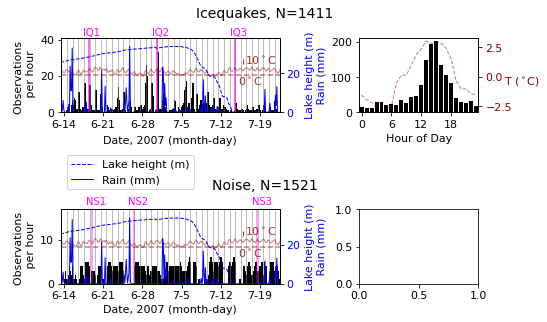

In [21]:

plt.rcParams.update({'font.size': 11})



fig,axes = plt.subplots(figsize = (width2,height1))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(2,5)
gs.update(wspace=4, hspace=1.3)






tpad = 20
tfont = 14

title = f'                                          Icequakes, N={N}'   
XX='IQ'#label for event line
ymax = 41
YY = 42
titleN = f'                                          Noise, N={NN}'
XXN='NS'#label for event line
ymaxN = 17
YYN = 18 
dtf = pd.DateOffset(1) #offset pink labels above date bars
dailyTempDiff = getDailyTempDiff(garciaDF_H,garciaDF_D,**plt_kwargs)




## Bar plot, Temp and Lake/Precip
ax = plt.subplot(gs[0,0:3])

ax.set_ylim(0,ymax)
ax.set_xlabel('Date, 2007 (month-day)',labelpad=6)
ax.set_xlim(tstart,tend)

figureFunctions2.plotBar(cat_orig,cat00,Kopt,barWidth=.3,timeBin='H',byCluster=False,**plt_kwargs)

figureFunctions2.plotTemp(garciaDF_3H,ax=ax,**plt_kwargs)   

figureFunctions2.plotLake(garciaDF_3H,ax=ax,ylabel='right',legend=False,**plt_kwargs)

for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='gray',linestyle='-',linewidth=1,alpha=0.3) 

###plot bars where sgrams were sampled
for i, da in enumerate(rand_date_list):
    ax.axvline(da,c='fuchsia',linestyle='-',linewidth=1.5,alpha=.8) 
    ax.text(da - dtf,YY,f'{XX}{i+1}',color='fuchsia',fontsize=10)#,rotation=90)
    

ax.set_title(title, pad=tpad,fontsize=tfont)
    
## Bar plot, Temp and Lake/Precip
ax = plt.subplot(gs[1,0:3])


ax.set_ylim(0,ymaxN)
ax.set_xlabel('Date, 2007 (month-day)',labelpad=4)
ax.set_xlim(tstart,tend)

figureFunctions2.plotBar(cat_origN,cat00N,KoptN,barWidth=.3,timeBin='H',byCluster=False,**plt_kwargs)

figureFunctions2.plotTemp(garciaDF_3H,ax=ax,**plt_kwargs)   

figureFunctions2.plotLake(garciaDF_3H,ax=ax,ylabel='right',legend=True,bb1=0,bb2=1.8,**plt_kwargs)

for i in range(numDays):
    ax.axvline(hourMaxTemp[i],c='gray',linestyle='-',linewidth=1,alpha=0.3) 

    
###plot bars where sgrams were sampled
for i, da in enumerate(rand_date_listN):
    
    ax.axvline(da,c='fuchsia',linestyle='-',linewidth=1.5,alpha=.5) 
    ax.text(da - dtf,YYN,f'{XXN}{i+1}',color='fuchsia',fontsize=10)#,rotation=90)
    
ax.set_title(titleN, pad=tpad,fontsize=tfont)

### plot hourly
ax = plt.subplot(gs[0,3:5])


#plot Bars
figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,**plt_kwargs)
# ax.set_title(title, pad=4,fontsize=10);

ax = plt.subplot(gs[1,3:5])

#plot Bars
figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=ax,labelpad=10,**plt_kwargs)
# ax.set_ylabel('Obersevations \n per hour',labelpad=6)

# ax.set_title(titleN, pad=4,fontsize=10);



plt.savefig(pathFig2 + f'Figure_2.pdf',bbox_inches='tight')

# Figure 3 - Spectra and Sample Spectrograms

## calc full (0-500Hz) means for all spectra

In [ ]:
calcSpectra = 1
if calcSpectra:
    list_rand_specMatsum = []
# for j,evID in enumerate(cat00.event_ID.iloc[0:50]):
    for j,evID in enumerate(cat00.event_ID):

        specMatsum,specMat,fSTFT2 = getSpectra_fromWF(evID,dataH5_path,station,channel,normed=True)

        if j == 0:
            specMatsum_sum = np.zeros(len(specMatsum))
            specMatsum_med = np.zeros(len(specMatsum))

        ax.plot(fSTFT2,specMatsum,alpha=.01,c='darkgray')


        specMatsum_sum += specMatsum

        specMatsum_med = np.vstack([specMatsum_med,specMatsum])





    specMatsum_mean = specMatsum_sum / (j+1)
    specMatsum_med = np.median(specMatsum_med,axis=0)
    sstd = np.std(specMatsum_med,axis=0)



    list_rand_specMatsumN = []
    # for j,evID in enumerate(cat00N.event_ID.iloc[0:50]):
    for j,evID in enumerate(cat00N.event_ID):
        specMatsumN,specMatN,fSTFT2N = getSpectra_fromWF(evID,dataH5_pathN,station,channel,normed=True)

        if j == 0:
            specMatsum_sumN = np.zeros(len(specMatsumN))
            specMatsum_medN = np.zeros(len(specMatsumN))

        ax.plot(fSTFT2N,specMatsumN,alpha=.01,c='darkgray')


        specMatsum_sumN += specMatsumN

        specMatsum_medN = np.vstack([specMatsum_medN,specMatsumN])


    specMatsum_meanN = specMatsum_sumN / (j+1)
    specMatsum_medN = np.median(specMatsum_medN,axis=0)
    sstdN = np.std(specMatsum_medN,axis=0)



## plot figure 3

In [ ]:
if calcSpectra:
    plt.rcParams.update({'font.size': 12})


    fig,axes = plt.subplots(figsize = (width2,height1*2))#,sharex=True,constrained_layout=True)
    gs = gridspec.GridSpec(6, 6)
    gs.update(wspace=1.5, hspace=.5)


    flabel1 = 1550
    flabel1N = 3120
    FS = 14#font size for fmin and fmax
    ymax = 1750
    ymaxN = 3500

    ## Bar plot, Temp and Lake/Precip
    ax = plt.subplot(gs[0:2,0:3])

    ax.set_ylabel('20*log10(|m/s$^2$|$^2$)')

    ax.plot(fSTFT2,specMatsum_mean,c='k',label='$mean$',lw=3)
    ax.plot(fSTFT2,specMatsum_mean+sstd,c='k',label='$\pm1 std$',lw=1)
    ax.plot(fSTFT2,specMatsum_mean-sstd,c='k',lw=1)

    ax.axvline(x=1/winLen_Sec,color='r',label='$1/L_{W}$',lw=2,alpha=.8)  


    ax.axvline(x=fmin,color='blue',ls='--',lw=2)
    ax.axvline(x=fmax,color='blue',ls='--',lw=2)
    ax.text(fmin+1, flabel1,'$f_{min}$',c='b',fontsize=FS)
    ax.text(fmax+1, flabel1,'$f_{max}$',c='b',fontsize=FS)


    ax.set_xlabel('$f$ (Hz)')
    ax.set_xlim(0,300)
    ax.set_ylim(0,ymax)

    ax.legend(loc='upper right',bbox_to_anchor=(1,1))
    ax.set_title('Icequakes',pad=tpad,fontsize=tfont)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()
    plt.grid()



    for i, evID in enumerate(randID):
        axs = plt.subplot(gs[i+2,0:3],ymargin=.1)

        specMat,x = getSgram(path_proj,evID,station)
        figureFunctions2.plotSgram(specMat,evID,tSTFT,fSTFT,ax=axs)#, **plt_kwargs)
        axs.set_xlabel('t (s)',labelpad=4)
        axs.set_ylabel('$f$ (s)',labelpad=4)

        datte = str(pd.to_datetime('200' + str(evID)).date())[2:]
        timme = str(pd.to_datetime('200' + str(evID)).time())
        plt.title(f'{XX}{i+1} - {datte} {timme}',color='k',pad=2)

        if i != 2:
    #         axs.set_xticks([]) 
            axs.set_xticklabels('')     
            axs.set_xlabel('')         
        if i != 1:
            axs.set_ylabel('')
    #         axs.set_yticklabels('')
    #         axs.set_yticks([]) 


    ###### NOISE #####

    ## Bar plot, Temp and Lake/Precip
    ax = plt.subplot(gs[0:2,3:])



    ax.plot(fSTFT2N,specMatsum_meanN,c='k',label='$mean$',lw=3)
    ax.plot(fSTFT2N,specMatsum_meanN+sstdN,c='k',label='$\pm1 std$',lw=1)
    ax.plot(fSTFT2N,specMatsum_meanN-sstdN,c='k',lw=1)


    ax.axvline(x=fmin,color='blue',ls='--',lw=2)
    ax.axvline(x=fmax,color='blue',ls='--',lw=2)
    ax.text(fmin+2, flabel1N,'$f_{min}$',c='b',fontsize=FS)
    ax.text(fmax+2, flabel1N,'$f_{max}$',c='b',fontsize=FS)
    ax.axvline(x=1/winLen_Sec,color='r',label='$1/L_{W}$',lw=2,alpha=.8)  


    ax.set_xlabel('$f$ (Hz)')
    ax.set_xlim(0,300)
    ax.set_ylim(0,ymaxN)

    # ax.legend(loc='upper right',bbox_to_anchor=(1,1))
    ax.set_title('Noise',pad=tpad,fontsize=tfont)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()
    plt.grid()




    for i, evID in enumerate(randIDN):
        axs = plt.subplot(gs[i+2,3:],ymargin=.1)

        specMat,x = getSgram(path_projN,evID,station)
        figureFunctions2.plotSgram(specMat,evID,tSTFTN,fSTFTN,ax=axs)#, **plt_kwargs)
        axs.set_xlabel('t (s)',labelpad=4)
    #     axs.set_ylabel('$f$ (s)',labelpad=4)

        datte = str(pd.to_datetime('200' + str(evID)).date())[2:]
        timme = str(pd.to_datetime('200' + str(evID)).time())
        plt.title(f'{XXN}{i+1} : {datte} {timme}',color='k',pad=2)

        if i != 2:
    #         axs.set_xticks([]) 
            axs.set_xticklabels('')     
            axs.set_xlabel('')         
    #     if i != 1:
        axs.set_ylabel('')
    #         axs.set_yticklabels('')
    #         axs.set_yticks([]) 


    plt.savefig(pathFig2 + f'Figure_3.pdf',bbox_inches='tight')

# Figure 4 - SpecUFEx Workflow and Reconstructing Spectra

In [ ]:
plt.rcParams.update({'font.size': 8})

LFS=11
tpad = 4
tfont=14

evID = randID[0]

fig,axes = plt.subplots(figsize = (width2,height1))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(3,8)
gs.update(wspace=.1, hspace=1.8)

circle1 = plt.Circle((0, 0), 0.2, color='r')
ax.add_patch(circle1)

ax = plt.subplot(gs[0,0:2])
specMat,x = getSgram(path_proj,evID,station)
figureFunctions2.plotSgram(specMat,evID,tSTFT,fSTFT,ax=ax)
ax.set_title('Spectrogram',pad=tpad+1,fontsize=tfont)
ax.set_ylabel('$f$ (Hz)',rotation=0,labelpad=18,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)


ax = plt.subplot(gs[0,4])
ax.set_title('Dict',pad=tpad,fontsize=tfont)
figureFunctions2.plotW(W_new,numPatterns,fSTFT,aspect=.3,ax=ax)
ax.set_ylabel('$f$ (Hz)',rotation=0,labelpad=18,fontsize=LFS)
ax.set_xlabel('$P$',fontsize=LFS)


ax = plt.subplot(gs[0,6:8])
ax.set_title('ACM',pad=tpad,fontsize=tfont)
figureFunctions2.plotACM(evID, pathACM, order_swap,tSTFT,numPatterns,ax=ax)
ax.set_ylabel('$P$',rotation=0,labelpad=10,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)

# ax.set_ylabel('$P$')

ax = plt.subplot(gs[1,0:2])
ax.set_title('ACM',pad=tpad,fontsize=tfont)
figureFunctions2.plotACM(evID, pathACM, order_swap,tSTFT,numPatterns,ax=ax)
ax.set_ylabel('$P$',rotation=0,labelpad=10,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)




ax = plt.subplot(gs[1,4])
figureFunctions2.plotEB(EB_new,aspect=1,ax=ax)
ax.set_title('EB',pad=tpad,fontsize=tfont)
ax.set_xlabel('$S$',labelpad=0,fontsize=LFS)
ax.set_ylabel('$P$',rotation=0,labelpad=10,fontsize=LFS)




ax = plt.subplot(gs[1,6:8])
figureFunctions2.plotSTM(evID, pathSTM,tSTFT,ax=ax)
ax.set_title('STM',pad=tpad,fontsize=tfont)
ax.set_ylabel('$S$',rotation=0,labelpad=10,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)
                 
ax = plt.subplot(gs[2,0:2])
ax.set_title('STM',pad=tpad,fontsize=tfont)
figureFunctions2.plotSTM(evID, pathSTM,tSTFT,ax=ax)
ax.set_ylabel('$S$',rotation=0,labelpad=10,fontsize=LFS)
ax.set_xlabel('t (s)',fontsize=LFS)



#### plot math symbols ###

ax = plt.subplot(gs[0,5])
circle1 = plt.Circle((0.08, 0.5), 0.07, color='k')
ax.add_patch(circle1)
ax.set_aspect('equal')
ax.axis('off')


ax = plt.subplot(gs[1,5])
circle1 = plt.Circle((0.08, 0.5), 0.07, color='k')
ax.add_patch(circle1)
ax.set_aspect('equal')
ax.axis('off')


ax = plt.subplot(gs[0,2])
ax.text(.5,.4,r'$\approx$',fontsize=20)
ax.axis('off')

ax = plt.subplot(gs[1,2])
ax.text(.5,.4,r'$\approx$',fontsize=20)
ax.axis('off')


ax = plt.subplot(gs[2,2])
ax.text(.5,.4,r'$\rightarrow$',fontsize=20)
ax.axis('off')



## plot FP
ax = plt.subplot(gs[2,4])
ax.set_title('Fingerprint',pad=tpad+2,fontsize=tfont)
figureFunctions2.plotFP(path_proj,outfile_name,evID,ax=ax)
ax.set_aspect('equal')
ax.set_ylabel('$S(t)$',rotation=0,labelpad=14,fontsize=LFS)
ax.set_xlabel('$S(t+1)}$',rotation=0,labelpad=0,fontsize=LFS)
# plt.tight_layout()
plt.savefig(pathFig2 + f'Figure_4.pdf',bbox_inches='tight')

### see PVE for PCs

In [ ]:

PCA_df, numPCA_80, cum_pve = PVEofPCA(path_proj,outfile_name,cat00,numPCMax=numStates**2,cum_pve_thresh=.8,stand=False);
PCA_dfN, numPCA_80N, cum_pveN = PVEofPCA(path_projN,outfile_nameN,cat00N,numPCMax=numStates**2,cum_pve_thresh=.8,stand=False)

In [ ]:
numPCA_80,cum_pve,numPCA_80N,cum_pveN

## Do PCA on FP for chosen number of PCs (3 for plotting, more for whatever)

In [ ]:
stand = False #standard scalar before PCA

In [ ]:
sklearn_pca, PCA_df, Y_PCA = PCAonFP(path_proj,outfile_name,cat00,numPCA=numPCA_80,stand=stand)
sklearn_pcaN, PCA_dfN, Y_PCAN = PCAonFP(path_projN,outfile_nameN,cat00N,numPCA=numPCA_80N,stand=stand)

In [ ]:
sklearn_pca3, PCA_df3, __ = PCAonFP(path_proj,outfile_name,cat00,numPCA=3,stand=stand)
sklearn_pca3N, PCA_df3N, __ = PCAonFP(path_projN,outfile_nameN,cat00N,numPCA=3,stand=stand)

## Silh score and cluster validation for 80% variance PC'


Add cluster labels to cat00

In [ ]:
## silh score and validation
##making rep catalog


##can force K here
Kmax=10
range_n_clusters_all = list(range(2,Kmax+1))


cat00, catall, Kopt, maxSilScore, avgSils, sse,cluster_labels_best,ss_best,euc_dist_best = calcSilhScore(path_proj,outfile_name,cat00,range_n_clusters_all,numPCA=numPCA_80,X='PCA', stand=stand);

print('Event optimum number of clusters:: ',Kopt)


cat00N, catallN, KoptN, maxSilScoreN, avgSilsN, sseN,cluster_labels_bestN,ss_bestN,euc_dist_bestN = calcSilhScore(path_projN,outfile_nameN,cat00N,range_n_clusters_all,numPCA=numPCA_80N,X='PCA', stand=stand);


print('Noise optimum number of clusters:: ',KoptN)


In [ ]:
cat00

## Silh score and cluster validation, rep events

#### pick which Kopt to use, do kmeans and validate clustering


In [ ]:
# ## silh score and validation
# ##making rep catalog


# ##can force K here
# Kmax=10


# range_n_clusters = [3]

# PCA_df_SS, catall, Kopt, __, __, __,cluster_labels_best,__,__ = calcSilhScore(path_proj,outfile_name,cat00,range_n_clusters,numPCA=numPCA_80,X='PCA',stand=stand);

# print('Event optimum number of clusters:: ',Kopt)

# range_n_clustersN = [4]

# PCA_df_SSN, catallN, KoptN, __, __, __,cluster_labels_bestN,__,__ = calcSilhScore(path_projN,outfile_nameN,cat00N,range_n_clustersN,numPCA=3,X='PCA',stand=stand);


# print('Noise optimum number of clusters:: ',KoptN)


# Figure 5, PCA

I argue that we don't need to normalize the fingerprint data -- the data are already standardized in some way, because they are probability-weigthed counts......... but we can normalize them by the max or something

In [ ]:
plt.scatter(PCA_df_80_SSN.PC2,PCA_df_80_SSN.PC3,s=1)

In [ ]:
## Plot PCA for Kopts, show rep events

fig,axes = plt.subplots(figsize = (width2,height1))
plt.box(False)
plt.xticks(ticks=[])
plt.yticks(ticks=[])

# gs = gridspec.GridSpec(2,2)
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Icequakes',fontsize=tfont)


figureFunctions2.plotPCA(PCA_df_80_SS,catall,Kopt,ax=ax, fig=fig, size=2,size2=50, alpha=.15,labelpad = 5,fontsize=8,**plt_kwargs)
ax = fig.add_subplot(122, projection='3d')
ax.set_title('Noise',fontsize=tfont)

figureFunctions2.plotPCA(PCA_df_80_SSN,catallN,KoptN,ax=ax, fig=fig, size=2,size2=50, alpha=.15,labelpad = 5,fontsize=8,**plt_kwargs)

plt.subplots_adjust(wspace=.3)

# Figure 6

### plot SSE and Kopt for noise and icequakes

## SSE

In [ ]:

#v2: 

plt.rcParams.update({'font.size': 14})

tpad = 50
title = f'Icequakes'

titleN = f'Noise'
XXN='NS'#label for event line
ymaxN = 31

tpad=0
tfont=20

fig,axes = plt.subplots(figsize = (width2,height1))#,sharex=True,constrained_layout=True)


## PLot Silh Ev
ax = plt.subplot(121)
ax.set_title('Icequakes',fontsize=tfont)
ax.plot(range_n_clusters_all,sse,'k')
ax.plot(Kopt, sse[Kopt-2],color='orange',marker='*',linestyle='None',ms=15,alpha=.5,label='$K_{opt}$')
ax.legend()#loc='upper right',bbox_to_anchor=(1.7,.5))

ax.set_xticks([int(r) for r in range_n_clusters_all])
ax.set_xticklabels([str(r) for r in range_n_clusters_all])    

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Squared standard error')

ax.grid()

ax.set_xlabel('Number of Clusters',labelpad=4)
ax.set_xlim(2,10)
# ax.set_ylim(100000,175000)

ax = plt.subplot(122)
ax.set_title('Noise',fontsize=tfont)
ax.plot(range_n_clusters_all,sseN,'k',label='Icequakes')
ax.plot(KoptN, sseN[KoptN-2],color='orange',marker='*',ms=15,alpha=.5)



ax.set_xticks([int(r) for r in range_n_clusters_all])
ax.set_xticklabels([str(r) for r in range_n_clusters_all])    

ax.set_xlabel('Number of clusters')
ax.set_ylabel('')

ax.grid()

ax.set_xlabel('Number of Clusters',labelpad=4)
ax.set_xlim(2,10)
# ax.set_ylim(0,60000)
plt.subplots_adjust(wspace=.3)
plt.savefig(pathFig2 + f'Figure_6b.pdf',bbox_inches='tight')


In [ ]:
#v2: 

plt.rcParams.update({'font.size': 14})

tpad = 50
title = f'Icequakes'

titleN = f'Noise'
XXN='NS'#label for event line
ymaxN = 31

tpad=0

fig,axes = plt.subplots(figsize = (width1,height1))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(1,1)
gs.update(wspace=0,hspace=0)



## PLot Silh Ev
ax = plt.subplot(gs[0])
ax.plot(range_n_clusters_all,avgSilsN,'k:',label='Noise')

ax.plot(range_n_clusters_all,avgSils,'k',label='Icequakes')


ax.plot(Kopt, avgSils[Kopt-2],color='orange',marker='*',linestyle='None',ms=15,alpha=.5,label='$K_{opt}$')

ax.legend()


ax.plot(KoptN, avgSilsN[KoptN-2],color='orange',marker='*',ms=15,alpha=.5)



ax.set_xticks([int(r) for r in range_n_clusters_all])
ax.set_xticklabels([str(r) for r in range_n_clusters_all])    

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Mean silhouette score')

ax.grid()

ax.set_xlabel('Number of Clusters',labelpad=4)
ax.set_xlim(2,10)
# ax.set_ylim(0,1)

plt.savefig(pathFig2 + f'Figure_5_MSS_v1.pdf',bbox_inches='tight')


# Figure 7 - representative FPs

## Make catalog of rep events

In [ ]:
cat_orig.head()
# cat00.head()

In [ ]:
cat_orig = pd.read_csv(path_Cat)


In [ ]:
cat_orig = pd.read_csv(path_Cat)
cat_orig['event_ID'] = [str(int(evv)) for evv in cat_orig['event_ID']]



# cat_orig['PC1'] = PCA_df.PC1
# cat_orig['PC2'] = PCA_df.PC2
# cat_orig['PC3'] = PCA_df.PC3



cat_orig['Cluster'] = PCA_df.Cluster
cat_orig['SS'] = PCA_df.SS
cat_orig['euc_dist'] = PCA_df.euc_dist



cat_orig['datetime'] = [pd.to_datetime(i) for i in cat_orig.datetime]
cat_orig['datetime2']= [pd.to_datetime(i) for i in cat_orig.datetime]
cat_orig = cat_orig.set_index('datetime2')

# if 'BB_Gorner_Event' in key: ## arg fix TS 2021 5 17
#     cat00['date_index'] = [pd.to_datetime('2007' + a[4:]) for a in cat00['date_index']]

#     cat00['datetime2']= cat00['date_index']
    
cat00['datetime'] = cat00['date_index']

# catall= pd.DataFrame()

# for k in range(1,Kopt+1):

#     exec(f"cat0 = cat00.where(cat00.Cluster=={k}).dropna()")

#     cat0 = getTopFCat.getTopFCat(cat0,topF,startInd=startInd,distMeasure = "SilhScore")
#     exec(f"cat{k} = cat0")
#     catall = catall.append(cat0)
    
# catall.head()

# catall['datetime_index'] = [pd.to_datetime(d) for d in catall.datetime]
# catall.sort_values(by='datetime_index');

cat00 = pd.merge(cat00,cat_orig,on='event_ID', suffixes=('', '_drop'))
cat00.drop([col for col in cat00.columns if 'drop' in col], axis=1, inplace=True)
cat00 = cat00.set_index('date_index')

In [ ]:
cat_origN = pd.read_csv(path_CatN)
cat_origN['event_ID'] = [str(int(evv)) for evv in cat_origN['event_ID']]



cat_origN['PC1'] = PCA_dfN.PC1
cat_origN['PC2'] = PCA_dfN.PC2
cat_origN['PC3'] = PCA_dfN.PC3
cat_origN['Cluster'] = PCA_dfN.Cluster
cat_origN['SS'] = PCA_dfN.SS
cat_origN['euc_dist'] = PCA_dfN.euc_dist



cat_origN['datetime'] = [pd.to_datetime(i) for i in cat_origN.datetime]
cat_origN['datetime2']= [pd.to_datetime(i) for i in cat_origN.datetime]
cat_origN = cat_origN.set_index('datetime2')

# if 'BB_Gorner_Event' in key: ## arg fix TS 2021 5 17
#     cat00['date_index'] = [pd.to_datetime('2007' + a[4:]) for a in cat00['date_index']]

#     cat00['datetime2']= cat00['date_index']
    
cat00N['datetime'] = cat00N['date_index']





# catallN= pd.DataFrame()

# for k in range(1,KoptN+1):

#     exec(f"cat0 = cat00N.where(cat00N.Cluster=={k}).dropna()")

#     cat0 = getTopFCat.getTopFCat(cat0,topF,startInd=startInd,distMeasure = "SilhScore")
#     exec(f"cat{k}N = cat0")
#     catallN = catallN.append(cat0)
    
# catallN.head()

# catallN['datetime_index'] = [pd.to_datetime(d) for d in catallN.datetime]
# catallN.sort_values(by='datetime_index');

cat00N = pd.merge(cat00N,cat_origN,on='event_ID', suffixes=('', '_drop'))
cat00N.drop([col for col in cat00N.columns if 'drop' in col], axis=1, inplace=True)
cat00N = cat00N.set_index('date_index')

In [ ]:
catallN

# Figure 7 Representative data and ML output


In [ ]:
plt.rcParams.update({'font.size': 8})

count =0
tpad=13

bW = 2#spine bar width
bA = 1
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)


gs = gridspec.GridSpec(len(catallN)+len(catall)+2, 10)

# gs.update(left=0.05, right=0.35, wspace=.3, hspace=1)
gs.update(wspace=.3, hspace=.25)



for i, evID in enumerate(catall.event_ID):
    
    
    k = int(catall.Cluster.iloc[i])
    
    
    
    ##plot wf
    ax=plt.subplot(gs[i,0:3])
    wf_zeromean = figureFunctions2.plotWF(str(evID),dataH5_path,station,channel,fmin,fmax,fs,tSTFT,colorBy='cluster',k=k,ax=ax,**plt_kwargs)


    if k == 1:
        ax.set_ylabel('Velocity',labelpad=1)
        ax.set_title('                                                  Icequakes',fontsize=tfont,pad=tpad)   

    else:
        ax.set_title('')
        ax.set_ylabel('')
        
    if k ==Kopt:    
        ax.set_xlabel('t (s)',labelpad=4)   
        
    else:
        ax.set_xlabel('')
        ax.set_xlabel('')
        ax.set_xticklabels('')
    
    
    
    ##plot arrow00
    ax=plt.subplot(gs[i,3])

    if k==1:

        ax.text(-.3,.4,r'$\rightarrow$',fontsize=20)
        
    else:
        ax.text(0,.4,r'$\rightarrow$',fontsize=20)  
    ax.axis('off')
      
        
        
#     plot sgram:
    ax = plt.subplot(gs[i,4:7])


    specMat,x = getSgram(path_proj,str(evID),station)
    figureFunctions2.plotSgram(specMat,str(evID),tSTFT,fSTFT,ax=ax)
#     figureFunctions2.plotSpines(cat=catall,k=k,axs=ax,barWidth=bW,alphaBar=bA,**plt_kwargs)

    ax.set_title('')

    
    if i ==0:    
        ax.set_ylabel('$f$ (Hz)',labelpad=1)

    else:
        ax.set_title('')
        ax.set_ylabel('')
        
    if i ==len(catall.event_ID)-1:    
        ax.set_xlabel('t (s)',labelpad=4)   
    else:
        ax.set_xlabel('')
        ax.set_xlabel('')
        ax.set_xticklabels('')

        
    ##plot arrow1
    ax = plt.subplot(gs[i,7:8])
    if k ==1:

        ax.text(-.3,.4,r'$\rightarrow$',fontsize=20)
        
    else:
        ax.text(0,.4,r'$\rightarrow$',fontsize=20)  
    ax.axis('off')
      
    
    ### plot FP
    ax=plt.subplot(gs[i,8:9])    
    figureFunctions2.plotSpines(cat=catall,k=k,axs=ax,barWidth=bW,alphaBar=bA,**plt_kwargs)
    figureFunctions2.plotFP(path_proj,outfile_name,evID,ax=ax)
    ax.set_aspect('equal')

    if k == 1:
        ax.set_ylabel('$S(t)$',labelpad=1)
    else:
        ax.set_ylabel('')
        ax.set_aspect('equal')
    if k == Kopt:    
        ax.set_xlabel('$S(t+1)$')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
        
        

##############################
##### NOISENOISENOISENOISE
##############################



for i, evID in enumerate(catallN.event_ID):
    
    k = int(catallN.Cluster.iloc[i])
    print(k)
    i = i + Kopt + 1
    ##plot wf
    ax=plt.subplot(gs[i,0:3])
    wf_data = figureFunctions2.plotWF(str(evID),dataH5_pathN,station,channel,fminN,fmaxN,fs,tSTFTN,colorBy='cluster',k=k,ax=ax,**plt_kwargs)

    ax.set_ylabel('')        

    if k ==1:    
        ax.set_title('                                               Noise',fontsize=tfont,pad=tpad)   
#         ax.set_ylabel('Velocity',labelpad=1)

    else:
        ax.set_title('')
        ax.set_ylabel('')
#         ax.set_yticklabels('')        

        
    if k ==KoptN:
        ax.set_xlabel('t (s)',labelpad=4)   
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
    
    
    
    ##plot arrow1
    ax = plt.subplot(gs[i,3:4])
    ax.text(0,.3,r'$\rightarrow$',fontsize=20)  
    ax.axis('off')
    
    
    
    
    
    
    ##plot sgram

    ax=plt.subplot(gs[i,4:7])
    specMat,x = getSgram(path_projN,str(evID),station)
    figureFunctions2.plotSgram(specMat,str(evID),tSTFTN,fSTFTN,ax=ax)
#     figureFunctions2.plotSpines(cat=catall,k=k,axs=ax,barWidth=bW,alphaBar=1, **plt_kwargs)

    ax.set_title('')
    ax.set_ylabel('')
#     ax.set_yticklabels('')        
        

    if k ==KoptN:    
        ax.set_xlabel('t (s)',labelpad=4)   
    else:
        ax.set_xlabel('')
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
#     ##plot arrow2
    ax = plt.subplot(gs[i,7:8])
    ax.text(0,.4,r'$\rightarrow$',fontsize=20)        
    ax.axis('off')
  
    
    ### plot FP
    ax=plt.subplot(gs[i,8:9]) 
    figureFunctions2.plotSpines(cat=catallN,k=k,axs=ax,barWidth=bW,alphaBar=bA,**plt_kwargs)
    figureFunctions2.plotFP(path_projN,outfile_nameN,evID,ax=ax)


    ax.set_ylabel('')
    ax.set_aspect('equal')
    
    
    if k ==KoptN:    
        ax.set_xlabel('$S(t+1)$')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        


    
    
plt.savefig(pathFig2 + f'Figure_7.pdf',bbox_inches='tight')

# Figure 8 - Hourly clusters

In [ ]:
plt.rcParams.update({'font.size': 12})
title = 'Icequakes'
titleN = 'Noise'

tfont = 14
tpad = 6

fig,axes = plt.subplots(figsize = (width1,height1))#,sharex=True)#,constrained_layout=True)


gs = gridspec.GridSpec(len(catallN)+1, 2)

# gs.update(left=0.05, right=0.35, wspace=.3, hspace=1)
gs.update(wspace=.5, hspace=.5)


### ICEQUAKE PROPORTION HOURLY
# ax = plt.subplot(gs[0,0])

# figureFunctions2.plotHourBarStack(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=15,**plt_kwargs)
# ax.set_ylabel('Proportion \n per hour   ', labelpad=8)
# ax.set_ylim(0,1)
# ax.set_xlim(0,23)
# ax.set_xlabel('')
# ax.set_xticklabels([])   

### ICEQUAKES BY CLUSTER HOURLY
ax.set_title(title,fontsize=tfont,pad=tpad)

for k in range(1,Kopt+1):
    
    i = k-1
    
    ax = plt.subplot(gs[i,0])
    
#     figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,colorBy='cluster',k=k,**plt_kwargs)
    
    if k == 1:
        figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,label='none',colorBy='cluster',k=k,**plt_kwargs)
        ax.set_title(title,fontsize=tfont,pad=tpad)  
    else:
        figureFunctions2.plotHourBar(cat00,Kopt,dailyTempDiff,ax=ax,labelpad=10,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
        ax.set_ylabel('')
        
    
    if k != Kopt:        
        ax.set_xlabel('')
        ax.set_xticklabels([])  
    if k == 2:
        ax.set_ylabel('Number of \n observations',labelpad=8)
    
#     ax.set_yticklabels([])  

        
        
# ### NOISE PROPORTION HOURLY
# axN = plt.subplot(gs[0,1])
# figureFunctions2.plotHourBarStack(cat00N,KoptN,dailyTempDiff,ax=axN,labelpad=15,**plt_kwargs)
# axN.set_ylabel('')
# axN.set_ylim(0,1)
# axN.set_xlim(0,23)



### NOISE BY CLUSTER HOURLY
for k in range(1,KoptN+1):
    
    i = k-1
    
    ax = plt.subplot(gs[i,1])
    
    if k == 1:
        ax.set_title(titleN,fontsize=tfont,pad=tpad)  
        figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=ax,labelpad=20,label='right',colorBy='cluster',k=k,**plt_kwargs)

    if k != 1:
        figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=ax,labelpad=10,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
        ax.set_ylabel('')
#         ax.set_yticks([])   
    else:
        figureFunctions2.plotHourBar(cat00N,KoptN,dailyTempDiff,ax=ax,labelpad=8,label='none',colorBy='cluster',k=k,**plt_kwargs)
        
    if k != KoptN:
        ax.set_xticklabels([]) 
        
        ax.set_xlabel('')

plt.savefig(pathFig2 + f'Figure_8.pdf',bbox_inches='tight')


# Figure 9 - clusters through season w/ hydro and GPS


plot strain? No - just use GPS. -- the triangle where it's calculated seems to be a little too far from our study site -- would prefer less-processed GPS as a clearer indicator of glacier velocity.


In [ ]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams.update({'font.size': 12})
fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True)#,constrained_layout=True)


# gs = gridspec.GridSpec(KoptN,4)
gs = gridspec.GridSpec(KoptN+Kopt+1,1)
# gs.update(left=0.05, right=0.35, wspace=.3, hspace=1)
gs.update(wspace=.6, hspace=.15)

tpad = 6


gpsstations = [24,34,36,37]

timecode = '3H'
datatype = ''


title = 'Icequakes'
textY = 16  

titleN = 'Noise'
textYN = 17.5

for k in range(1,Kopt+1):
    
    ax=plt.subplot(gs[k-1,0])
#     ax.set_ylim(0,20)

    figureFunctions2.plotBarCluster(cat00,k=k,barWidth=.3,timeBin='H',ax=ax,**plt_kwargs)
    if k == 1:

        figureFunctions2.plotLake(garciaDF_3H,legend=None,ylabel='right',ax=ax,**plt_kwargs)
        ax.set_title(title,fontsize=tfont,pad=tpad)
        ax.set_ylabel('Observations \n per hour',labelpad=6)

        for gss in gpsstations:
            staaa = 'gps' + str(gss)
            gps_var = staaa + datatype + '_' + timecode
            gps_data = garciaDF_3H[gps_var]
            figureFunctions2.plotGPS(gps_data,ax=ax,ylabel='none',**plt_kwargs)
    
    elif k==3:
        for gss in gpsstations:
            staaa = 'gps' + str(gss)

            gps_var = staaa + datatype + '_' + timecode
            gps_data = garciaDF_3H[gps_var]
            figureFunctions2.plotGPS(gps_data,ax=None,ylabel='right',**plt_kwargs)

    else:
        figureFunctions2.plotLake(garciaDF_3H,legend=None,ylabel=None,ax=ax,**plt_kwargs)
        for gss in gpsstations:
            staaa = 'gps' + str(gss)
            gps_var = staaa +  datatype + '_' + timecode
            gps_data = garciaDF_3H[gps_var]
            figureFunctions2.plotGPS(gps_data,ax=ax,ylabel='none',**plt_kwargs)
        
    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,c='k',linestyle='--',linewidth=2, alpha=1)   
   

    if k == Kopt:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')

        
        
ax=plt.subplot(gs[Kopt,0])
ax.axis('off')



for k in range(1,KoptN+1):
    
    ax=plt.subplot(gs[k-1+Kopt+1,0])
#     ax.set_ylim(0,11)

    figureFunctions2.plotBarCluster(cat00N,k=k,barWidth=.3,ax=ax,**plt_kwargs)
    figureFunctions2.plotLake(garciaDF_3H,legend=None,ylabel=None,ax=ax,**plt_kwargs)

    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    ax.axvline(x=supraDraint,c='k',linestyle='--',linewidth=2, alpha=1)   
    
    
    if k == 1:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_title(titleN,fontsize=tfont,pad=tpad)
        
    if k == 2:
        for gss in gpsstations:
            staaa = 'gps' + str(gss)
            gps_var = staaa + datatype + '_' + timecode
            gps_data = garciaDF_3H[gps_var]
            figureFunctions2.plotGPS(gps_data,ax=ax,ylabel='right',**plt_kwargs)
    else:
        for gss in gpsstations:
            staaa = 'gps' + str(gss)
            gps_var = staaa + datatype + '_' + timecode
            gps_data = garciaDF_3H[gps_var]
            figureFunctions2.plotGPS(gps_data,ax=ax,ylabel='none',**plt_kwargs)

    if k == KoptN:
        ax.set_xlabel('Date, 2007 (month-day)')
        ax.tick_params(axis='x',labelrotation=0)
        
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
plt.savefig(pathFig2 + f'Figure_9_gps.pdf',bbox_inches='tight')

# Figure 10 Map by cluster



### set map subplot params

In [ ]:
size1 = 1000
a1 = .7


### plot map full - by cluster

In [ ]:
 ##v3 separate map for each cluster
##settings for yellow bars
plotMap = 1
if plotMap:
    plt.rcParams.update({'font.size': 12})


    # if 'Event' in key:
    fig,axes = plt.subplots(figsize = (width2,height1))#,sharex=True,constrained_layout=True)

    
    
    gs = gridspec.GridSpec(2, 2)

    gs.update(wspace=0.02, hspace=0.07)

    #### plot map view and stations

    color_list = ['all',1,2,3,4,5]


    for k in range(0,Kopt+1):
    # for k in [0,1]:    
        ax = plt.subplot(gs[k])
        ax.set_aspect('equal')
        ax.tick_params(axis='x',labelrotation=45)

        if k == 0:
            figureFunctions2.plotMap(cat00,
                    ax=ax,
                    colorBy='cluster',
                    size=15,
                    alpha=.4,
                    **plt_kwargs); #'oneCluster''cluster';'all';'datetime'

            ax.set_xlabel('')

        else:
            figureFunctions2.plotMap(cat00,
                    ax=ax,
                    colorBy='oneCluster',
                    k=k,
                    size=15,
                    alpha=.4,
                    **plt_kwargs); #'oneCluster''cluster';'all';'datetime'

        if k%2!=0:
            ax.set_yticklabels('')
    #         ax.set_yticks([])

        if k<2:
            ax.set_xticklabels('')
#             ax.set_xticks([])
        if k==2:
            fss = 15
            ax.set_ylabel('                             Northing (m)',labelpad=30,fontsize=fss)        

        if k==2:
            ax.set_xlabel('                                       Easting (m)',labelpad=30,fontsize=fss)              


        figureFunctions2.plotStations(stn,station,ax=ax)   


    ax.tick_params(axis='x',labelrotation=45)
    
    fss = 15

    plt.savefig(pathFig2 + f'Figure_10.pdf',bbox_inches='tight')



## 10b location features

In [ ]:
# get location features


print('getting location features for events...')    
df_loc = getLocationFeatures(cat00,stn,station)

In [ ]:

# ### ### ### ### ### ### ### ### ### ### ### ### 
# ### ### ### ### ### ### ### ### ### ### ### ### 
# ####### LOCATION LOCATION LOCATION
# ### ### ### ### ### ### ### ### ### ### ### ### 
# ### ### ### ### ### ### ### ### ### ### ### ### 

plt.rcParams.update({'font.size': 12})

fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(2, 2)

gs.update(wspace=0.2,hspace=0.2)

## plot Depth boxplot
maxDepth = 15
ax = plt.subplot(gs[0,0])
ax.invert_yaxis()
# ax.set_ylim(20,0)

figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'Depth_m',ax=ax,**plt_kwargs)

#lines for depth limits
ax.axhline(0,color='k',ls='--')
ax.axhline(maxDepth,color='k',ls='--')


ax.set_ylabel('')
ax.set_title('Depth (m)',pad=10)
ax.set_xticks([])
ax.set_xticklabels('')
ax.set_xlabel('')
# ax.grid('off')



## plot Depth boxplot
ax = plt.subplot(gs[0,1])
ax.invert_yaxis()
ax.set_ylim(maxDepth,0)

figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'Depth_m',ax=ax,**plt_kwargs)
ax.set_ylabel('')
ax.set_title('Depth (m)',pad=10)
ax.set_xticks([])
ax.set_xticklabels('')
ax.set_xlabel('')
# ax.grid('off')

## plot 3D dist boxplot
ax = plt.subplot(gs[1,0])
figureFunctions2.plotFeatureBoxPlot(df_loc,Kopt,'DistXYZ_m',ax=ax,**plt_kwargs)
ax.set_ylabel('')
ax.set_title('Station \n distance (m)',pad=10)
# ax.set_xlabel('Cluster',labelpad=4,fontsize=FS)
# ax.grid('off')
ax.set_xlabel('')
ax.set_xticks([])
ax.set_xticklabels('')

plt.savefig(pathFig2 + f'Figure_10b.pdf',bbox_inches='tight')


# Fig 11 - Clustered event features boxplots 



A box plot (or box-and-whisker plot) shows the distribution of quantitative data in a way that facilitates comparisons between variables or across levels of a categorical variable. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the inter-quartile range.



Proportion of the IQR past the low and high quartiles to extend the plot whiskers. Points outside this range will be identified as outliers.



In [ ]:

gF = 1
if gF:
    
    print('getting features for events...')
    df = getFeatures(cat00,filetype,fmin,fmax,fs,path_WF,nfft,dataH5_path,station,channel)
    
    print('getting features for noise...')    
    dfN = getFeatures(cat00N,filetypeN,fminN,fmaxN,fsN,path_WFN,nfftN,dataH5_pathN,station,channel)
    print('done!')

In [ ]:
if gF:
    plt.rcParams.update({'font.size': 8})

    fig,axes = plt.subplots(figsize = (width1,height2))#,sharex=True,constrained_layout=True)
    gs = gridspec.GridSpec(5,7)
    gs.update(wspace=3, hspace=0.1)


    FS = 13 #'Cluster' x label

    tfont = 14
    tpad = 6
    title = 'Icequakes'
    titleN = 'Noise'

    textYN = 8
    textY = 7.8

    ### ### ### ### ### ### ### ### ### ### ### ### 
    ### ### ### ### ### ### ### ### ### ### ### ### 
    ## plot boxplot for RSAM
    ax = plt.subplot(gs[0,0:3])
    ax.set_title(title,fontsize=tfont,pad=tpad)
    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    figureFunctions2.plotFeatureBoxPlot(df,Kopt,'log10RSAM',ax=ax,**plt_kwargs)
    ax.set_ylabel('log10(RSAM) ($m/s^2$)',labelpad=13)
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xlabel('')
    # ax.grid('off')


    ### ### ### ### ### ### ### ### ### ### ### ### 
    ### ### ### ### ### ### ### ### ### ### ### ### 
    ## plot boxplot for P2P
    ax = plt.subplot(gs[1,0:3])
    figureFunctions2.plotFeatureBoxPlot(df,Kopt,'log10P2P',ax=ax,**plt_kwargs)
    ax.set_ylabel('log10(P2P) ($m/s^2$)',labelpad=13)
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xlabel('')
    # ax.grid('off')


    ### ### ### ### ### ### ### ### ### ### ### ### 
    ## plot Boxplot for SC
    ax = plt.subplot(gs[2,0:3])
    figureFunctions2.plotFeatureBoxPlot(df,Kopt,'SC',ax=ax,**plt_kwargs)
    # ax.set_xlabel('Cluster',labelpad=4,fontsize=FS)
    ax.set_ylabel('Spectral centroid ($Hz$)',labelpad=8)
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xlabel('')
    # ax.grid('off')




    ### ### ### ### ### ### ### ### ### ### ### ### 
    ### ### ### ### ### ### ### ### ### ### ### ### 
    ####### NOISENOISENOISE
    ### ### ### ### ### ### ### ### ### ### ### ### 
    ### ### ### ### ### ### ### ### ### ### ### ### 


    ### ### ### ### ### ### ### ### ### ### ### ### 
    ### ### ### ### ### ### ### ### ### ### ### ### 
    ## plot boxplot for RSAM NOISE
    ax = plt.subplot(gs[0,3:])
    ax.set_title(titleN,fontsize=tfont,pad=tpad)
    ax.axvline(x=subDraint,c='k',linestyle='--',linewidth=2, alpha=1)
    figureFunctions2.plotFeatureBoxPlot(dfN,KoptN,'log10RSAM',ax=ax,**plt_kwargs)
    # ax.set_ylabel('log10(RSAM)',labelpad=12)
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xlabel('')
    # ax.grid('off')


    ### ### ### ### ### ### ### ### ### ### ### ### 
    ### ### ### ### ### ### ### ### ### ### ### ### 
    ## plot boxplot for P2P NOISE
    ax = plt.subplot(gs[1,3:])
    figureFunctions2.plotFeatureBoxPlot(dfN,KoptN,'log10P2P',ax=ax,**plt_kwargs)
    # ax.set_ylabel('log10P2P',labelpad=10)
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xlabel('')
    # ax.grid('off')


    ### ### ### ### ### ### ### ### ### ### ### ### 
    ## plot Boxplot for SC NOISE
    ax = plt.subplot(gs[2,3:])
    figureFunctions2.plotFeatureBoxPlot(dfN,KoptN,'SC',ax=ax,**plt_kwargs)
    # ax.set_ylabel('Spectral centroid (Hz)',labelpad=4)
    ax.set_ylabel('')
#     ax.set_xlabel('Cluster',labelpad=5,fontsize=FS)
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xlabel('')
    # ax.grid('off')




    # # plt.tight_layout()
    plt.savefig(pathFig2 + f'Figure_11.pdf',bbox_inches='tight')

# Figure 12 clustering spectra

In [ ]:
plt.savefig(pathFig2 + f'Figure_12.pdf',bbox_inches='tight')

# Figure 13 Visualizing spectral reconstruction

In [ ]:
plt.rcParams.update({'font.size': 12})

fig,axes = plt.subplots(figsize = (width2,height1))#,sharex=True)#,constrained_layout=True)
gs = gridspec.GridSpec(1,8)
gs.update(wspace=.9)


tpad = 4
tfont=14

# Plot NMF dictionary
ax=plt.subplot(gs[0,0])
figureFunctions2.plotW(W_new,numPatterns,fSTFT,aspect=.7,ax=ax)
ax.set_title('Dict',pad=tpad,fontsize=tfont)



##plot dot
ax = plt.subplot(gs[0,1])
circle1 = plt.Circle((0.1, 0.5), 0.1, color='k')
ax.add_patch(circle1)
ax.set_aspect('equal')
ax.axis('off')


#Plot Emissions 
ax=plt.subplot(gs[0,2])
figureFunctions2.plotEB(EB_new,aspect=1.5,ax=ax)
ax.set_title('EB',pad=tpad,fontsize=tfont)

##plot equals sign
ax = plt.subplot(gs[0,3])
ax.text(-.5,.5,r'$=$',fontsize=20)
ax.axis('off')

##plot RMM     
ax = plt.subplot(gs[0,4])
figureFunctions2.plotRMM(RMM,fSTFT,numStates,aspect=.7,ax=ax)
ax.set_title('RMM',pad=tpad,fontsize=tfont)



##plot arrow
ax = plt.subplot(gs[0,5])
ax.text(0,.5,r'$\rightarrow$',fontsize=20)
ax.axis('off')


# ax = plt.subplot(gs[0,6:7])
sel_state_all = [0,1,2,3,4]
# figureFunctions2.plotReconstructedStates(RMM,sel_state_all,fSTFT,lw=1,freq_list=None,ax=ax,**plt_kwargs)



# plt.savefig(pathFig2 + f'Figure_13.jpeg',bbox_inches='tight')

In [ ]:
plt.figure(figsize=(5,3))
sel_state_all = [4,5,6,7,8,9,10,11]
figureFunctions2.plotReconstructedStates(RMM,sel_state_all,fSTFT,lw=1,legend='outside',bb1=1.25,bb2=.5,freq_list=None,normed='median',**plt_kwargs)

# plt.savefig(pathFig2 + f'Figure_11b.pdf',bbox_inches='tight')
##add labels to plot for states instead of color legend

# Figure 13 - Compare actual and reconstructed Spectra (normalized and non-normalized)

In [ ]:
k = 3
peak_rec_state, peak_spec, scale = CalcDiffPeak(path_proj,cat00,k,RMM,sel_state,station)
print(peak_rec_state, peak_spec, scale)

kN=4
peak_rec_stateN, peak_specN, scaleN = CalcDiffPeak(path_projN,cat00N,kN,RMMN,sel_stateN,station)
print(peak_rec_stateN, peak_specN, scaleN)


In [ ]:
plt.rcParams.update({'font.size': 12})

fig,axes = plt.subplots(figsize = (width2,height2))#,sharex=True,constrained_layout=True)
gs = gridspec.GridSpec(2,1)
gs.update(wspace=.4, hspace=.4)

title='Icequakes'
titleN='Noise'
# freq_list = np.arange(fmin,fmax,10)

tpad=4

### ### ### ### ### ### ### ### ### ### ### ### 
## EVENT
ax = plt.subplot(gs[0])
ax.set_xlim(0,80)
ax.set_xlabel('$f$ (Hz)')

ax.set_ylabel('Normalized dB')
# ax.set_ylim(0,.5e9)
# R2=0
# ax.text(40,6e7,f'$MAE={MAE}$',fontsize=10)

ax.set_title(title,fontsize=tfont,pad=tpad)  
figureFunctions2.plotReconstructedStates(RMM,sel_state,fSTFT,lw=1,freq_list=None,normed='median',scale=peak_rec_state,**plt_kwargs)

ax.legend(loc='upper right',bbox_to_anchor=(1.2,1))

figureFunctions2.plotMedianSpectra(path_proj,cat00,Kopt,fSTFT,station,leg,normed='median',ax=ax,scale=peak_spec,**plt_kwargs)
plt.yscale('log')
# plt.xscale('log')


### ### ### ### ### ### ### ### ### ### ### ### 
## NOISE
ax = plt.subplot(gs[1])
ax.set_xlim(0,80)
# ax.set_ylim(0,2.25e7)
# ax.set_ylim(ymin=0)
ax.set_title(titleN,fontsize=tfont,pad=tpad)
  
figureFunctions2.plotReconstructedStates(RMMN,sel_stateN,fSTFTN,lw=1,freq_list=None,normed='median',scale=peak_rec_stateN,**plt_kwargs)



ax.legend(loc='upper right',bbox_to_anchor=(1.2,1))



figureFunctions2.plotMedianSpectra(path_projN,cat00N,KoptN,fSTFTN,station,legN,lw=1,normed='median',scale=peak_specN,ax=ax,**plt_kwargs)
ax.set_ylabel('Normalized dB')
ax.set_xlabel('$f$ (Hz)')


# state_minMAE = sel_stateN[kmaxN-1]

# ax.text(40,1.25e7,r'$R^2 _{S3}=$'+f'{r2_maxN:.3f}',fontsize=14,c=colors[kmaxN-1])



plt.yscale('log')
# plt.xscale('log')

plt.savefig(pathFig2 + f'Figure_13.pdf',bbox_inches='tight')

In [ ]:
# approximation.shape,pca_comp.shape

In [ ]:
# plt.rcParams['image.cmap']='magma'


# plt.subplots(figsize = (width2,height1*2))#,sharex=True,constrained_layout=True)
# L=8
# gs = gridspec.GridSpec(L//2,2)
# gs.update(wspace=1.5, hspace=.5)

# for i in range(L):
#     ax = plt.subplot(gs[i])
#     ax.set_title(i)
#     ax.set_aspect('equal')
#     plt.pcolormesh(np.reshape(pca_comp[i],(15,15)))

In [ ]:
# plt.figure()
# ax = plt.gca()
# ax.set_aspect('equal')
# plt.pcolormesh(np.reshape(approximation[0],(15,15)))
